In [47]:
# Data
import yfinance as yf
import pandas_datareader as web
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler

# Algorithms
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

# Model evaluation
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error

# Time series
from pmdarima import auto_arima
import statsmodels.api as sm
# from statsmodels.tsa.arima_model import ARIMA # deprecated
from statsmodels.tsa.arima.model import ARIMA 
from statsmodels.graphics.tsaplots import plot_acf

# Others
import warnings

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)

# Load data

In [3]:
# Load data

# Amazon vs Microsoft, Google, IBM 
# Daily return past 10 years 
data = yf.download(tickers="AMZN MSFT GOOGL IBM", period='10y', interval='1d')

[*********************100%***********************]  4 of 4 completed


In [4]:
# Save stock data - Close price (adjusted) 

stk_data = data[['Adj Close']]
stk_data.columns = stk_data.columns.droplevel()

In [5]:
stk_data.index

DatetimeIndex(['2011-08-12', '2011-08-15', '2011-08-16', '2011-08-17',
               '2011-08-18', '2011-08-19', '2011-08-22', '2011-08-23',
               '2011-08-24', '2011-08-25',
               ...
               '2021-07-29', '2021-07-30', '2021-08-02', '2021-08-03',
               '2021-08-04', '2021-08-05', '2021-08-06', '2021-08-09',
               '2021-08-10', '2021-08-11'],
              dtype='datetime64[ns]', name='Date', length=2516, freq=None)

In [6]:
# FX and market indices
# Trading dates may vary - will be adjusted

ccy_tickers = ['DEXJPUS', 'DEXUSUK']
idx_tickers = ['SP500', 'DJIA', 'VIXCLS']

ccy_data = web.DataReader(ccy_tickers, 'fred', start='2011-08-09', end='2021-08-09')
idx_data = web.DataReader(idx_tickers, 'fred', start='2011-08-09', end='2021-08-09')

For modeling, response (Y) and predictor (X) variables will be determined. Amazon stock pricing is the objective of this project. 

The data are represented with daily stock prices, but the response variable (Y) will be the weekly return of Amazon. The number of trading days a week will be assumed to be 5 days.

Independent variables (X) will include stock prices of correlated (likely) companies, market (foreign currency and indices) and lagged stock prices of Amazon. Returns will be rescaled using natural log. Logarithmic price scales tend to show less severe price increases or decreases than linear price scales - so it prevents small price changes being seen more trival than larger counterparts [reference](https://www.investopedia.com/terms/l/logarithmicscale.asp).


The major limitation of this pricing prediction model is that it only concerns correlated stocks and technical indicators, and leaving further investigations with other possible features used in fundamental analysis (i.e. performance reports, news). 



In [7]:
# Construct Y variable - AMZN stock price (5-day)

# To find correlations with other stocks, we need to get 5 day lagged price
# .diff() function produces 5-day returns after natural log rescaling
# .shift() function returns the stock prices that are 5 days later

periods = 5
Y = np.log(stk_data.loc[:, 'AMZN']).diff(periods).shift(-periods)
Y.name = Y.name + '_pred'

In [8]:
stk_data

,AMZN,GOOGL,IBM,MSFT
Date,,,,
2011-08-12,202.300003,282.167175,118.583801,20.112915
2011-08-15,202.949997,278.893890,121.960823,20.441450
2011-08-16,197.679993,269.769775,120.727028,20.441452
2011-08-17,195.929993,266.841827,120.896263,20.360809
2011-08-18,182.520004,252.692688,115.502869,19.893110
...,...,...,...,...
2021-08-05,3375.989990,2725.030029,141.145035,289.519989
2021-08-06,3344.939941,2714.770020,142.449997,289.459991
2021-08-09,3341.870117,2738.260010,141.250000,288.329987


In [9]:
# Construct X variables 

# 5-day returns for Correlated stocks - 'GOOGL', 'IBM', 'MSFT'
X1 = np.log(stk_data.loc[:, ('GOOGL', 'IBM', 'MSFT')]).diff(periods)

# 5-day returns for Foreign currency & Market indices
X2 = np.log(ccy_data).diff(periods)
X3 = np.log(idx_data).diff(periods)

# Lagged 5-day, 15-day, 30-day, 60-day AMZN returns 
X4 = [np.log(stk_data.loc[:, 'AMZN']).diff(i) for i in [periods, periods*3, periods*6,  periods*12]]
X4 = pd.concat(X4, axis=1)
X4.columns = ['AMZN_DT', 'AMZN_3DT', 'AMZN_6DT', 'AMZN_12DT']

In [10]:
# Combine all X variables

X = pd.concat([X1, X2, X3, X4], axis=1)

In [11]:
# Reconstruct dataset with X, Y variables
# Remove row records that contain at least one null values 
# It means that we only contains data corresponding to the dates of Y dataset

dataset = pd.concat([Y, X], axis=1).dropna()

In [12]:
# And also we are interested in seeing a weekly return
# So slicing with 5 day interval

dataset = dataset.iloc[::periods, :]

In [13]:
# Save the data

dataset.to_csv('StockData/PricingAMZN_Technical.csv')

# Descriptive analysis

In [14]:
dataset = pd.read_csv('StockData/PricingAMZN_Technical.csv', index_col=0, parse_dates=True)
dataset.head()

,AMZN_pred,GOOGL,IBM,MSFT,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,AMZN_DT,AMZN_3DT,AMZN_6DT,AMZN_12DT
2011-11-07,0.008855,0.026130,0.014464,0.006364,0.001154,-0.007275,0.006220,0.009439,-0.003678,0.016214,-0.110403,-0.057530,0.070146
2011-11-15,-0.124450,0.006868,0.007978,-0.008083,-0.010337,-0.016179,-0.014295,-0.006101,0.127600,-0.000734,-0.041896,0.024773,0.204519
2011-11-23,0.042169,-0.070037,-0.047572,-0.063337,0.005051,-0.016560,-0.062654,-0.055969,0.013928,-0.114845,-0.131823,-0.225564,-0.109785
2011-12-02,-0.015422,0.097020,0.068745,0.037161,0.002829,0.008049,0.071284,0.067776,-0.225176,0.072066,-0.072595,-0.175385,-0.102827
2011-12-09,-0.062913,0.011316,0.025507,0.018853,-0.003860,0.003202,0.008730,0.013621,-0.042307,-0.015422,-0.057820,-0.068810,-0.161135


In [15]:
# Get Y, X variables
Y = dataset.loc[:, 'AMZN_pred'].copy()
X = dataset.drop(columns='AMZN_pred').copy()

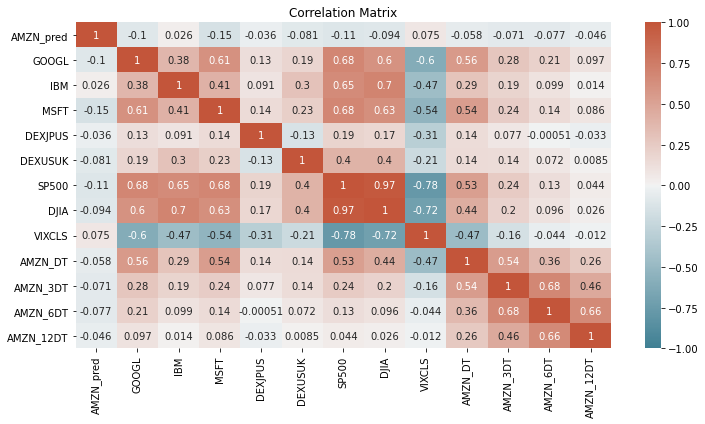

In [16]:
# Heatmap visualization

corr = dataset.corr()
plt.figure(figsize=(12,6))
plt.title('Correlation Matrix')
sns.heatmap(corr, annot=True, cbar=True, vmax=1, vmin=-1, cmap=sns.diverging_palette(220, 20, as_cmap=True)) # diverging
plt.show()

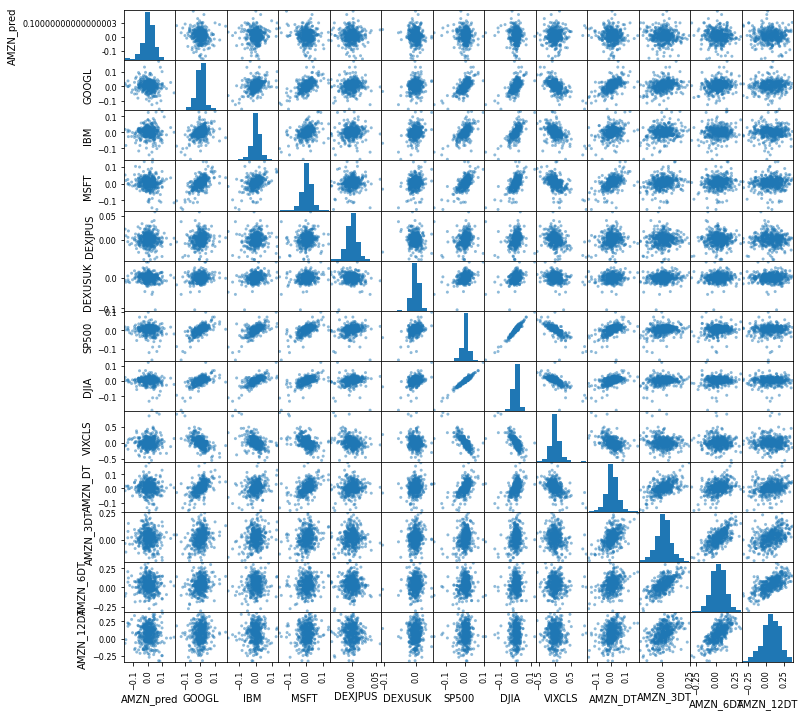

In [17]:
# Scatter plot visualization

scatter_matrix(dataset, figsize=(12,12))
plt.show()

No clear corrleation between AMZN ('AMZN_pred') and other stocks and markets. There are relatively strong negative correlation between VIXCLS and market indices and other stocks. Strong positive correlations are seen amongs lagged returns for Amazon. 

In [18]:
# Time series analysis

def tsa_seasonal_plot(r: pd.Series, period=52):
    model = sm.tsa.seasonal_decompose(r, period=period)
    fig= model.plot()
    fig.set_figheight(8)
    fig.set_figwidth(12)
    plt.show()

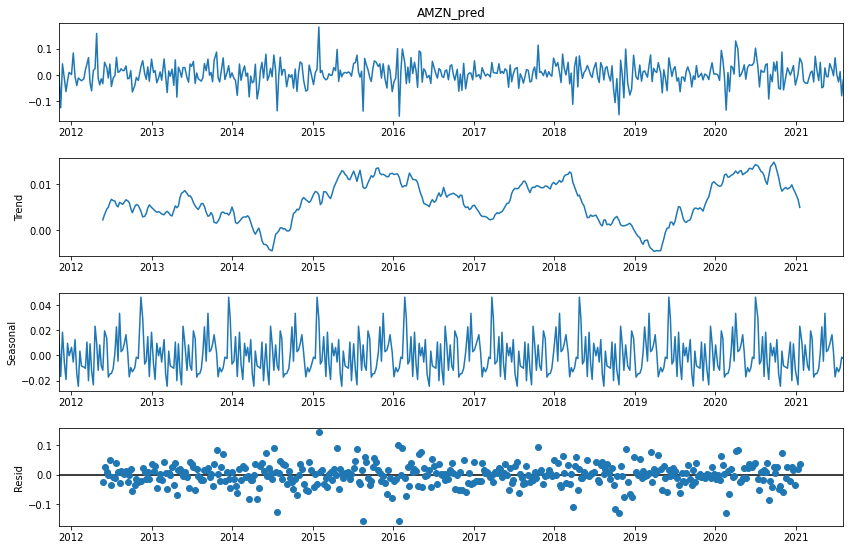

In [19]:
tsa_seasonal_plot(Y);

Amazon stocks have some trend fluctuations in returns. There has been an upward trend in the recent 2 years. The impact of Covid-19 (starting from early 2020) does not seem obvious to Amazon stock price.

# Modeling

It looks that additional data preparation is not necessary with clean and tidy dataset. Returns were log scaled so the additional preprocessing is not needed. Here, not many features are used so dimentional reduction may not be necessary.

In [20]:
# Regressors
# Using default parameters

models = [
    ('LR', LinearRegression()),
    ('LASSO', Lasso()),
    ('EN', ElasticNet()),
    ('DT', DecisionTreeRegressor()),
    ('RFR', RandomForestRegressor()),
    ('GBR', GradientBoostingRegressor()),
    ('ABR', AdaBoostRegressor()),
    ('SVR', SVR())
]

In [21]:
dataset

,AMZN_pred,GOOGL,IBM,MSFT,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,AMZN_DT,AMZN_3DT,AMZN_6DT,AMZN_12DT
2011-11-07,0.008855,0.026130,0.014464,0.006364,0.001154,-0.007275,0.006220,0.009439,-0.003678,0.016214,-0.110403,-0.057530,0.070146
2011-11-15,-0.124450,0.006868,0.007978,-0.008083,-0.010337,-0.016179,-0.014295,-0.006101,0.127600,-0.000734,-0.041896,0.024773,0.204519
2011-11-23,0.042169,-0.070037,-0.047572,-0.063337,0.005051,-0.016560,-0.062654,-0.055969,0.013928,-0.114845,-0.131823,-0.225564,-0.109785
2011-12-02,-0.015422,0.097020,0.068745,0.037161,0.002829,0.008049,0.071284,0.067776,-0.225176,0.072066,-0.072595,-0.175385,-0.102827
2011-12-09,-0.062913,0.011316,0.025507,0.018853,-0.003860,0.003202,0.008730,0.013621,-0.042307,-0.015422,-0.057820,-0.068810,-0.161135
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-06,0.000441,0.029384,-0.045842,0.032727,0.001175,-0.003835,0.011983,0.008279,0.025879,0.065153,0.082734,0.137642,0.086189
2021-07-14,-0.026555,0.013843,0.000000,0.009174,-0.005348,0.004485,0.003703,0.007224,0.007993,-0.004039,0.049053,0.134407,0.087860
2021-07-21,0.012507,-0.005380,0.010529,-0.003937,0.001725,-0.011543,-0.003575,-0.003879,0.092355,-0.026555,0.038979,0.093827,0.050395
2021-07-28,-0.078953,0.064845,0.003321,0.016984,-0.001453,0.013706,0.009578,0.003813,0.022088,0.012507,-0.018087,0.070520,0.069527


In [22]:
# Train, Test set
# As the dataset is time series,
# split sequentially  

validation_size = .2
split_point = int(dataset.shape[0] * (1-validation_size))
X_train, Y_train = X.iloc[:split_point], Y[:split_point]
X_test, Y_test = X.iloc[split_point:], Y.iloc[split_point:]

In [23]:
# Test for the best model
# Save K fold (10 folds) validation results for analysis
# Evaluate each model wih mean squaredd error

# Set up parameters for KFolds cv
num_folds = 10
scoring = 'neg_mean_squared_error'

names = []
kfold_results = [] # 10 folds cv
train_results = [] # mse
test_results = [] # mse

for name, model in models:
    names.append(name)
    ## Perform K fold test and save results
    kfold = KFold(n_splits=num_folds) 
    cv_results = -cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)

    ## Fit model and evaluate performances
    fitted = model.fit(X_train, Y_train)
    train_result = mean_squared_error(fitted.predict(X_train), Y_train)
    train_results.append(train_result)
    
    test_result = mean_squared_error(fitted.predict(X_test), Y_test)
    test_results.append(test_result)
    

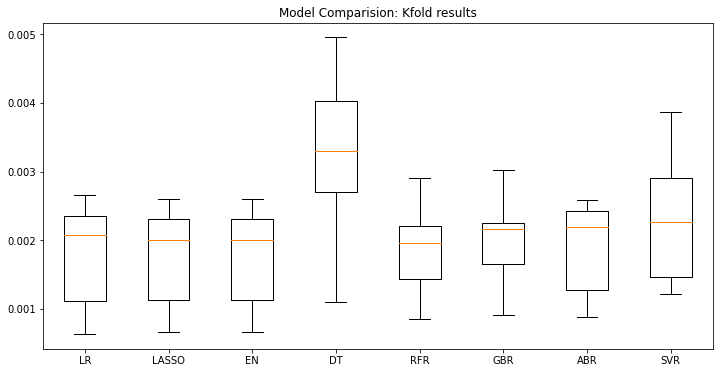

In [24]:
# Plotting the validation results

plt.boxplot(kfold_results)
plt.title('Model Comparision: Kfold results')
plt.xticks(ticks=np.arange(1, len(names)+1, 1), labels=names)
plt.show()

The boxplot shows a distribution of 10 discrete mean squared errors, resulted from kfold cross validations for each model/algorithm. Cross validation was performed on the training set only. So the higher the value, the worse the performance in general.

Linear models (**Linear Regression, LASSO, Elastic net**) performed comparatively better, whereas **ensemble models** are fairly okay. The good performance implies a good relationship between X and Y variable.

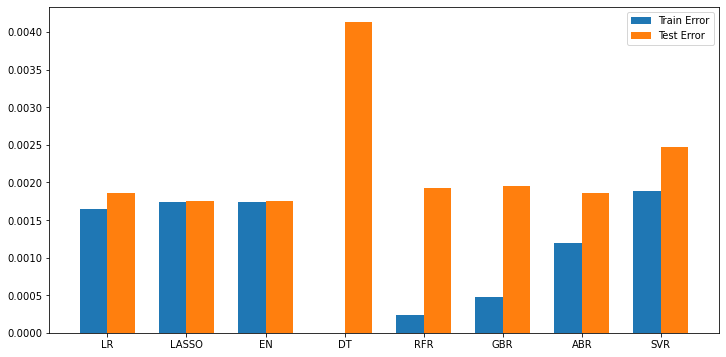

In [25]:
# Plotting the train and test errors

# A good tip to plot both errors in parallel 
loc = np.arange(len(names))
width = .35 

# fig = plt.figure()
# ax = fig.add_subplot(111)
plt.bar(loc - width/2, train_results, width=width, label='Train Error')
plt.bar(loc + width/2, test_results, width=width, label='Test Error')

plt.xticks(ticks=loc, labels=names)
plt.legend(loc='best')
plt.show()

**Decision tree** shows a significant issue with overfitting. Ensemble models (**Random forecst, Gradient boost and Ada boost regressors**) also overfit the train data given high test errors compared to train errors. 

Linear models also appears slighly overfit. **Lasso** and **Elastic net** decrease the gaps between train and test errors possibly from regularization.  

## Incorporate ARIMA
For an ARIMA model, lagged variables are not necessary. We fit **ARIMA(1,0,0) = first-order autoregressive model**.

$Ŷ_t = μ + ϕ1Yt-1$

In [26]:
# Remove the lagging features

usecols = X_train.columns.values.tolist()[:-4]
X_train_ARIMA = X_train.loc[:, usecols]
X_test_ARIMA = X_test.loc[:, usecols]

In [36]:
# Fit ARIMA(1,0,0) 
# Assuming no differencing and moving average(error) terms
# The predictor variables X are all exogenous

modelARIMA = ARIMA(endog=Y_train, exog=X_train_ARIMA, order=[1,0,0])
modelARIMA_fit = modelARIMA.fit()


/Users/jsuk/opt/anaconda3/envs/ml_fin/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/jsuk/opt/anaconda3/envs/ml_fin/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/jsuk/opt/anaconda3/envs/ml_fin/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [37]:
# Coefficients

modelARIMA_fit.params

const      0.005748
GOOGL      0.028119
IBM        0.119827
MSFT      -0.328991
DEXJPUS   -0.127019
DEXUSUK   -0.181357
SP500     -0.030951
DJIA       0.208275
VIXCLS     0.005463
ar.L1     -0.027084
sigma2     0.001653
dtype: float64

In [38]:
# Make a prediction with test set

start = len(X_train_ARIMA) - 1
end = len(X) -1
pred_ARIMA = modelARIMA_fit.predict(start=start, end=end, exog=X_test_ARIMA)[1:]
pred_ARIMA

/Users/jsuk/opt/anaconda3/envs/ml_fin/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


371    0.007091
372    0.006470
373    0.014224
374   -0.001157
375    0.005245
         ...   
459   -0.007644
460    0.004419
461    0.009836
462    0.000699
463    0.005458
Name: predicted_mean, Length: 93, dtype: float64

In [39]:
train_result_ARIMA = mean_squared_error(Y_train, modelARIMA_fit.fittedvalues)
test_result_ARIMA = mean_squared_error(Y_test, pred_ARIMA)

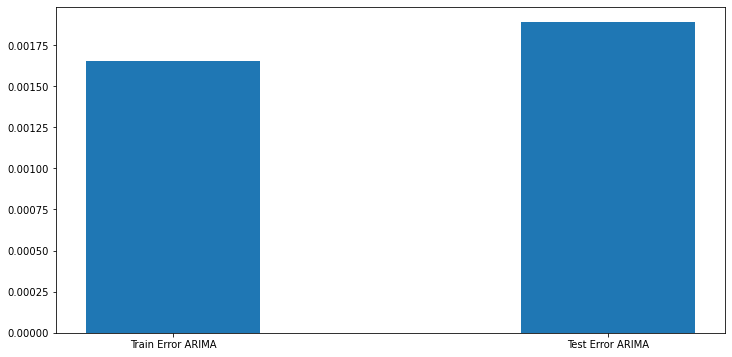

In [40]:
plt.bar(['Train Error ARIMA', 'Test Error ARIMA'], [train_result_ARIMA, test_result_ARIMA], width=0.4);

In [41]:
# Append to the model results

train_results.append(train_result_ARIMA)
test_results.append(test_result_ARIMA)

names.append('ARIMA')

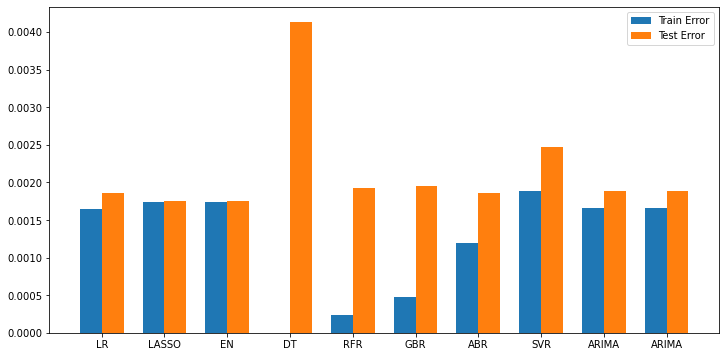

In [42]:
# Plotting the train and test errors

# A good tip to plot both errors in parallel 
loc = np.arange(len(names))
width = .35 

# fig = plt.figure()
# ax = fig.add_subplot(111)
plt.bar(loc - width/2, train_results, width=width, label='Train Error')
plt.bar(loc + width/2, test_results, width=width, label='Test Error')

plt.xticks(ticks=loc, labels=names)
plt.legend(loc='best')
plt.show()

## Modeling tuning - ARIMA
In the above ARIMA modeling, order (1,0,0) was used. However, it was not tested which order (p,d,q) will perform the best. So a grid search function will be created to calculate error given a combination of (p,d,q).

In [66]:
# Helper function to evaluate error of ARIMA model given training set

def evaluate_error_ARIMA(X_train, Y_train, arima_order:tuple):
    ''' Calculate mean squared error of ARIMA model, given a input arima order (p, d, q)
    Use train data X, Y to test the model fit and error
    '''
    model = ARIMA(endog=Y_train, exog=X_train, order=arima_order)
    model_fit = model.fit()
    error = mean_squared_error(Y_train, model_fit.fittedvalues) 
    
    return error
    

def evaluate_ARIMA_model(X_train, Y_train, p_values, d_values, q_values):
    ''' Find the best combination of orders for ARIMA model producing the minimum errors given
    the input sets of p, d, q values. Number of each p, d, q values can vary.
    '''
    best_score, best_pdq = float('inf'), None
    
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                
                # Fit model and test error
                try:
                    error = evaluate_error_ARIMA(X_train, Y_train, order)
                    if error < best_score:
                        best_score = error
                        best_pdq = order
                        if order != None:
                            print(f'ARIMA{order} MSE={error:.7f}')                                    
                except:
                    continue
    
    print(f'Best ARIMA{best_pdq} MSE={best_score:.7f}')


In [73]:
# Set up a list of p, d, q values

p_values = np.arange(0,3)
d_values = np.arange(0,3)
q_values = np.arange(0,3)

# Ignore errors from ARIMA package
warnings.filterwarnings('ignore')

In [72]:
evaluate_ARIMA_model(X_train_ARIMA, Y_train, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=0.0016542
ARIMA(0, 0, 1) MSE=0.0016531
ARIMA(0, 0, 2) MSE=0.0016412
ARIMA(1, 0, 2) MSE=0.0016388
ARIMA(2, 0, 1) MSE=0.0016381
Best ARIMA(2, 0, 1) MSE=0.0016381


ARIMA with an p, d, q order of (2, 0, 1) produced the minium error - although no significant differences are observed across all combinations. ARIMA(2, 0, 1) means the model with autoregression lag of two and moving average of one.

In [74]:
# Run ARIMA again with the best parameters
modelARIMA_tuned = ARIMA(endog=Y_train, exog=X_train_ARIMA, order=[2,0,1])
modelARIMA_tuned_fit = modelARIMA_tuned.fit()

# Make a prediction with test set

start = len(X_train_ARIMA) - 1
end = len(X) -1
pred_ARIMA_tuned = modelARIMA_tuned_fit.predict(start=start, end=end, exog=X_test_ARIMA)[1:]

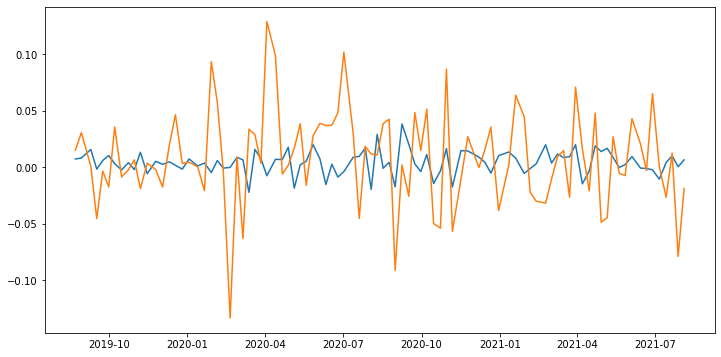

In [80]:
# Visualize the prediction vs actual 

pred_ARIMA_tuned.index = Y_test.index
plt.plot(pred_ARIMA_tuned);
plt.plot(Y_test);

The predicted values shows more flattened plot - less volatile.

In [92]:
np.exp(Y_test)

2019-08-23    1.015243
2019-08-30    1.030997
2019-09-10    1.001099
2019-09-17    0.955590
2019-09-24    0.996578
                ...   
2021-07-06    1.000441
2021-07-14    0.973795
2021-07-21    1.012585
2021-07-28    0.924084
2021-08-04    0.981337
Name: AMZN_pred, Length: 93, dtype: float64

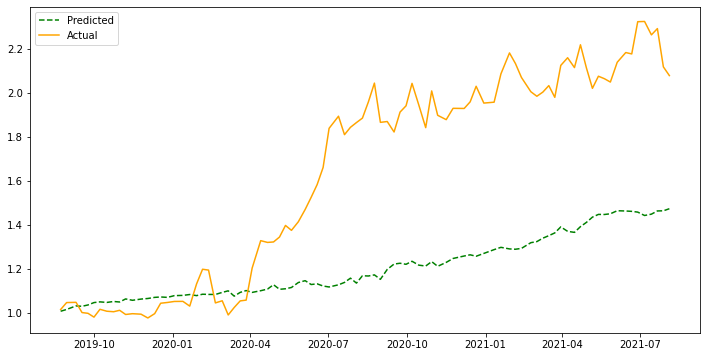

In [91]:
# Plot the actual price - cumulative 

plt.plot(np.exp(pred_ARIMA_tuned).cumprod(), 'g--', label='Predicted');
plt.plot(np.exp(Y_test).cumprod(), label='Actual', color='orange')
plt.legend(loc='best')
plt.show()

The model based on ARIMA captured the overall increasing trend. It performed fairly okay for the first 6 months. Deviation from the actual data increases afterwards. When the purpose is to predict the next day's price given the dataset rather than to predict prices several days/months from now, the model performs okay. 